In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import bayespy as bp
import numpy as np
import seaborn as sns

## Simple Example from [bayespy.org]()

Iteration 1: loglike=-5.842853e+01 (0.002 seconds)
Iteration 2: loglike=-5.660097e+01 (0.002 seconds)
Iteration 3: loglike=-5.659861e+01 (0.002 seconds)
Iteration 4: loglike=-5.659858e+01 (0.002 seconds)
Converged at iteration 4.


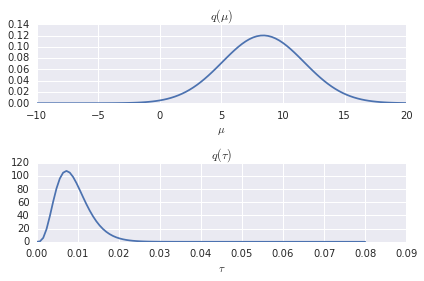

In [15]:
data = np.random.normal(5,10, size=(10,))
from bayespy.nodes import GaussianARD, Gamma
mu = GaussianARD(0, 1e-6)
tau = Gamma(1e-6, 1e-6)
y = GaussianARD(mu, tau, plates=(10,))

y.observe(data)

from bayespy.inference import VB
Q = VB(mu, tau, y)
Q.update(repeat=20)

bp.plot.pyplot.subplot(2,1,1)
bp.plot.pdf(mu, np.linspace(-10,20, num=100), name=r'\mu')
bp.plot.pyplot.subplot(2,1,2)
bp.plot.pdf(tau, np.linspace(1e-6,.08,num=100), name=r'\tau')
bp.plot.pyplot.tight_layout()
bp.plot.pyplot.show()


## Gaussian Process Example

In [16]:
from scipy.spatial import distance


# Some inputs
N = 200
X = np.random.randn(N, 1)

def dist(X):
    return distance.squareform(distance.pdist(X))


# Squared distance matrix
D = dist(X) ** 2

def exponentiated_square(parameters):
    lengthscale = np.exp(parameters[0])
    magnitude = np.exp(parameters[1])
    return magnitude**2 * np.exp(-D/lengthscale) + 1e-6 * np.identity(N)

def d_parameters(d_exponentiated_square, parameters):
    """ Backward gradient of exponentiated square w.r.t. parameters """
    lengthscale = np.exp(parameters[0])
    magnitude = np.exp(parameters[1])
    K = magnitude**2 * np.exp(-D/lengthscale)
    return [
        np.sum(d_exponentiated_square * K * D / lengthscale),
        np.sum(d_exponentiated_square * K * 2)
    ]

def inverse(K):
    return np.linalg.inv(K)

def d_covariance(d_inverse, K):
    """ Backward gradient of inverse w.r.t. covariance """
    invK = np.linalg.inv(K)
    return -invK.dot(d_inverse).dot(invK)

n_iter = 50
gp_len = np.zeros((n_iter,1))
gp_mag = np.zeros((n_iter,1))
noise = np.zeros((n_iter,1))

true_ls = 0.3
true_amp = 5
true_noise = 0.01

for i in range(n_iter):
    parameters = bp.nodes.MaximumLikelihood(np.log([1, 1]))
    Covariance = bp.nodes.Function(
        exponentiated_square,
        (parameters, d_parameters)
    )
    Lambda = bp.nodes.Function(
        inverse,
        (Covariance, d_covariance)
    )

    # Latent Gaussian process
    latent = bp.nodes.Gaussian(np.zeros(N), Lambda)

    # Observation noise precision
    tau = bp.nodes.Gamma(1e-3, 1e-3)

    # Observations node
    Y = bp.nodes.GaussianARD(latent, tau)

    # Create data
    K = exponentiated_square(np.log([true_ls, true_amp]))
    data = bp.nodes.Gaussian(np.zeros(N), np.linalg.inv(K + true_noise*np.identity(N))).random()
    Y.observe(data)

    # Run inference:
    Q = bp.inference.VB(Y, latent, tau, parameters)
    Q.optimize(parameters, collapsed=[latent, tau], maxiter=200, verbose=False)
    
    gp_len[i] = np.exp(parameters.get_moments()[0][0])
    gp_mag[i] = np.exp(parameters.get_moments()[0][1])
    noise[i] = tau.get_moments()[0]**(-1)


/home/main/anaconda2/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


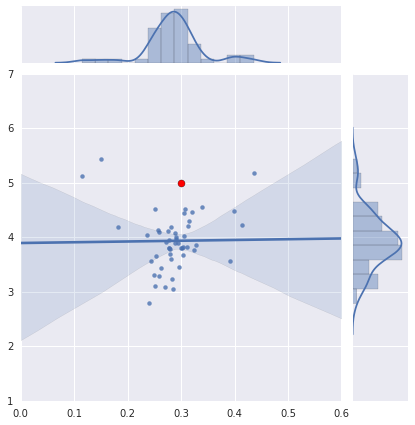

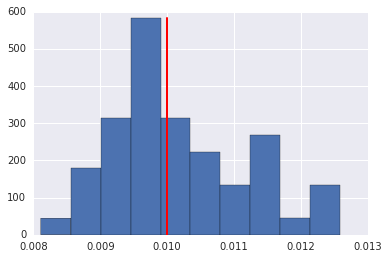

In [19]:
g = sns.JointGrid(gp_len, gp_mag)
g = g.plot(sns.regplot, sns.distplot)
plt.scatter(0.3, 5, s=50, c="red")
plt.figure()
n, bins, patches = plt.hist(noise_std, normed=True)
plt.plot([true_noise]*2, [0, int(np.max(n)) + 1], color="red",linewidth=2)